In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
import medmnist
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
data_flag = 'bloodmnist'

download = True
NUM_EPOCHS = 15
BATCH_SIZE = 64
lr = 0.001

In [3]:
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [5]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)


Using downloaded and verified file: C:\Users\Makhmudkozha\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Makhmudkozha\.medmnist\bloodmnist.npz


In [6]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = Block(in_channels, 16, kernel_size=3)
        self.layer2 = nn.Sequential(
            Block(16, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = Block(16, 64, kernel_size=3)
        self.layer4 = Block(64, 64, kernel_size=3)
        self.layer5 = nn.Sequential(
            Block(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # Use Softmax for multi-class classification
        if task != "multi-label, binary-class":
            self.fc.add_module("softmax", nn.Softmax(dim=-1))

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [8]:
# Lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()

        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training statistics
        train_loss += loss.item()

        if task != 'multi-label, binary-class':
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        else:
            predicted = (torch.sigmoid(outputs) > 0.5).to(torch.float32)
            train_total += targets.size(0) * targets.size(1)
            train_correct += accuracy_score(targets.cpu().numpy(), predicted.cpu().numpy(), average='micro') * targets.size(0)

    # Calculate training accuracy after each epoch
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    # Print epoch summary
    print(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_loss / len(train_loader):.4f}, '
          f'Accuracy: {train_accuracy:.2f}%')
    
from sklearn.metrics import accuracy_score, roc_auc_score   
# Evaluation on the test set
test_correct = 0
test_total = 0
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            outputs = outputs.sigmoid()
        else:
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)

            _, predicted = torch.max(outputs.data, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

    # Calculate test accuracy after each epoch
    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)

# Print test accuracy
print(f'Test Accuracy after Epoch {epoch + 1}: {test_accuracy:.2f}%')



Training Epoch [1/15], Loss: 2.0616, Accuracy: 19.16%
Training Epoch [2/15], Loss: 1.9724, Accuracy: 26.87%
Training Epoch [3/15], Loss: 1.7774, Accuracy: 49.73%
Training Epoch [4/15], Loss: 1.6960, Accuracy: 58.77%
Training Epoch [5/15], Loss: 1.6357, Accuracy: 66.08%
Training Epoch [6/15], Loss: 1.5907, Accuracy: 70.49%
Training Epoch [7/15], Loss: 1.5701, Accuracy: 71.54%
Training Epoch [8/15], Loss: 1.5611, Accuracy: 71.95%
Training Epoch [9/15], Loss: 1.5507, Accuracy: 72.82%
Training Epoch [10/15], Loss: 1.5254, Accuracy: 77.49%
Training Epoch [11/15], Loss: 1.5059, Accuracy: 78.72%
Training Epoch [12/15], Loss: 1.4945, Accuracy: 79.56%
Training Epoch [13/15], Loss: 1.4867, Accuracy: 79.92%
Training Epoch [14/15], Loss: 1.4798, Accuracy: 80.37%
Training Epoch [15/15], Loss: 1.4747, Accuracy: 80.87%
Test Accuracy after Epoch 15: 80.12%


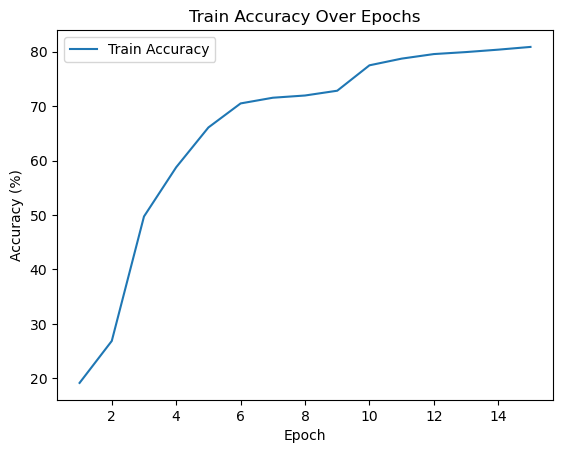

In [10]:
# Plotting
epochs = range(1, len(train_accuracies) + 1)

# Make sure test_accuracies has the same length as epochs
test_accuracies = test_accuracies[:len(train_accuracies)]

plt.plot(epochs, train_accuracies, label='Train Accuracy')
#plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy Over Epochs')
plt.legend()
plt.show()